In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
%matplotlib inline

In [6]:
# input batch size for training (default: 64)
batch_size = 64

# input batch size for testing (default: 1000)
test_batch_size = 1000

# number of epochs to train (default: 10)
epochs = 10

# learning rate (default: 0.01)
lr = 0.01

# SGD momentum (default: 0.5)
momentum = 0.5

# disables CUDA training
no_cuda = True

# random seed (default: 1)
seed = 1

# how many batches to wait before logging training status
log_interval = 10

# Setting seed for reproducibility.
torch.manual_seed(seed)

cuda = not no_cuda and torch.cuda.is_available()
print("CUDA: {}".format(cuda))

CUDA: False


In [7]:
if cuda:
    torch.cuda.manual_seed(seed)
cudakwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Precalcualted values.
])

train_set = datasets.MNIST(
    root='data',
    train=True,
    transform=mnist_transform,
    download=True,
)

test_set = datasets.MNIST(
    root='data',
    train=False,
    transform=mnist_transform,
    download=True,
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    **cudakwargs
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=test_batch_size,
    shuffle=True,
    **cudakwargs
)


## Loading the model.
Here we will focus only on `nn.Sequential` model types as they are easier to deal with. Generalizing the methods described here to `nn.Module` will require more work.

In [41]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
    def __str__(self):
        return 'Flatten()'

model = nn.Sequential(OrderedDict([
    ('conv2d_1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)),
    ('relu_1', nn.ReLU()),
    ('max_pooling2d_1', nn.MaxPool2d(kernel_size=2)),
    ('conv2d_2', nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)),
    ('relu_2', nn.ReLU()),
    ('dropout_1', nn.Dropout(p=0.25)),
    ('flatten_1', Flatten()),
    ('dense_1', nn.Linear(3872, 64)),
    ('relu_3', nn.ReLU()),
    ('dropout_2', nn.Dropout(p=0.5)),
    ('dense_2', nn.Linear(64, 10)),
    ('readout', nn.LogSoftmax())
]))

model.load_state_dict(torch.load('example_torch_mnist_model.pth'))

## Accessing the layers
A `torch.nn.Sequential` module serves itself as an iterable and subscriptable container for all its children modules.


In [42]:
for i, layer in enumerate(model):
    print('{}\t{}'.format(i, layer))

0	Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
1	ReLU ()
2	MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
3	Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
4	ReLU ()
5	Dropout (p = 0.25)
6	Flatten()
7	Linear (3872 -> 64)
8	ReLU ()
9	Dropout (p = 0.5)
10	Linear (64 -> 10)
11	LogSoftmax ()


Moreover `.modules` and `.children` provide generators for accessing layers.

In [22]:
for m in model.modules():
    print(m)

Sequential (
  (conv2d_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu_1): ReLU ()
  (max_pooling2d_1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2d_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu_2): ReLU ()
  (dropout_1): Dropout (p = 0.25)
  (flatten_1): Flatten (
  )
  (dense_1): Linear (3872 -> 64)
  (relu_3): ReLU ()
  (dropout_2): Dropout (p = 0.5)
  (dense_2): Linear (64 -> 10)
  (readout): LogSoftmax ()
)
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
ReLU ()
MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
ReLU ()
Dropout (p = 0.25)
Flatten (
)
Linear (3872 -> 64)
ReLU ()
Dropout (p = 0.5)
Linear (64 -> 10)
LogSoftmax ()


In [23]:
for c in model.children():
    print(c)

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
ReLU ()
MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
ReLU ()
Dropout (p = 0.25)
Flatten (
)
Linear (3872 -> 64)
ReLU ()
Dropout (p = 0.5)
Linear (64 -> 10)
LogSoftmax ()


## Getting the weigths.

In [26]:
conv2d_1_weight = model[0].weight.data.numpy()
conv2d_1_weight.shape

(32, 1, 3, 3)

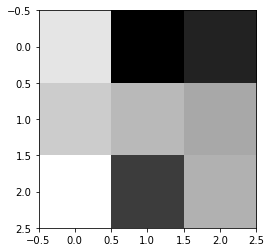

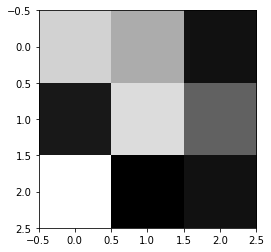

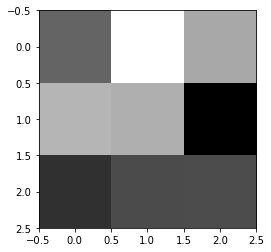

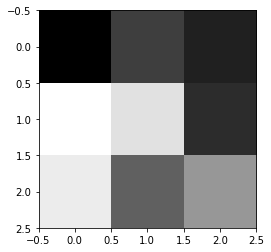

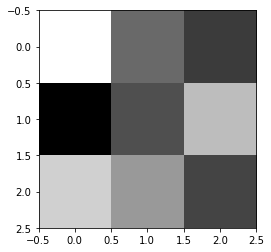

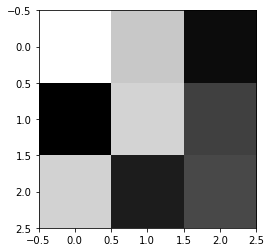

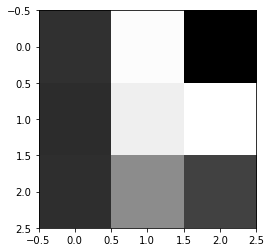

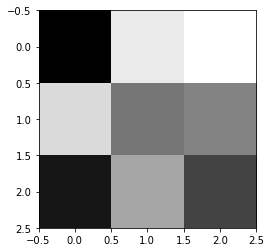

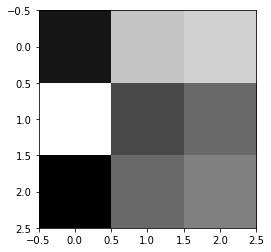

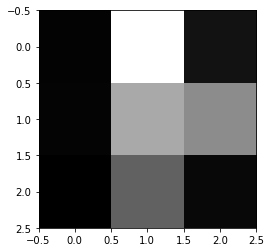

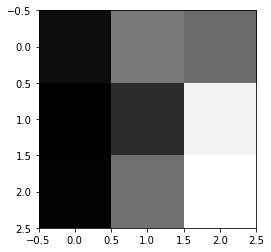

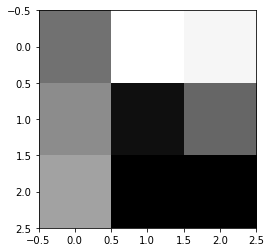

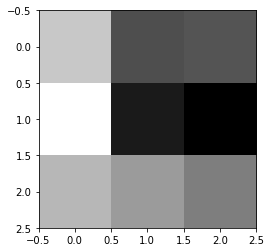

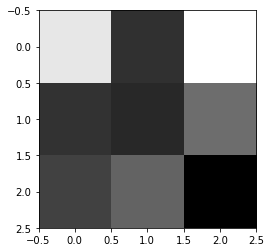

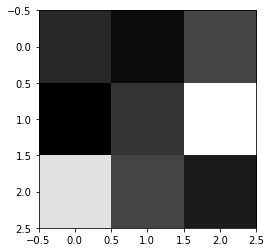

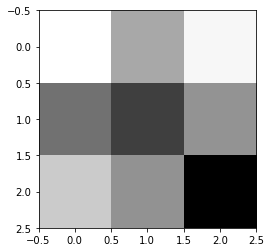

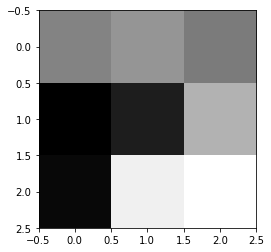

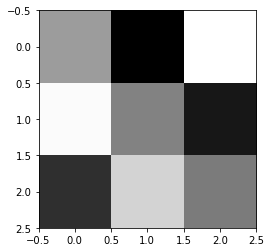

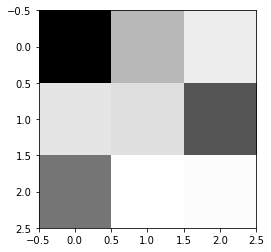

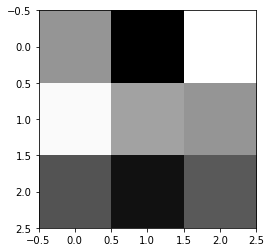

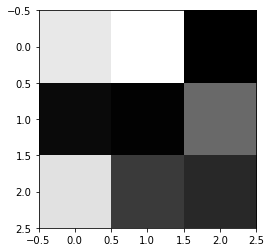

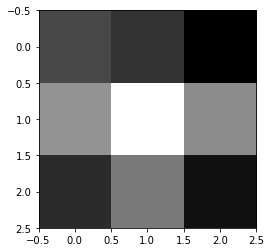

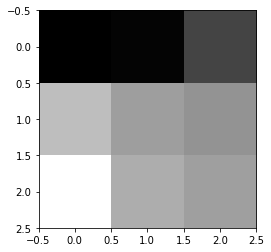

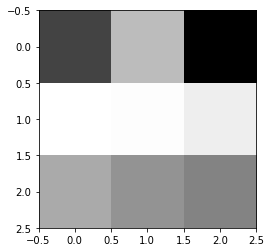

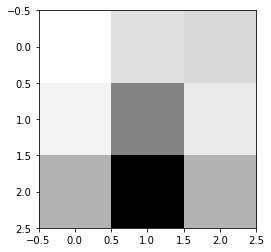

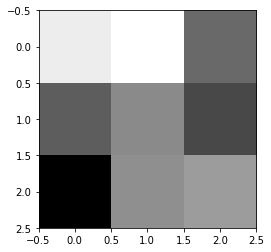

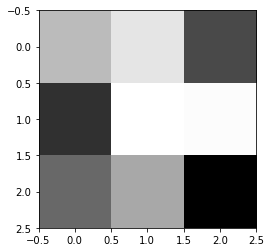

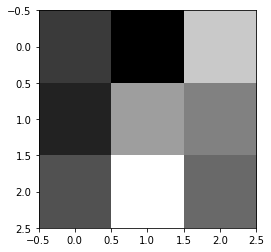

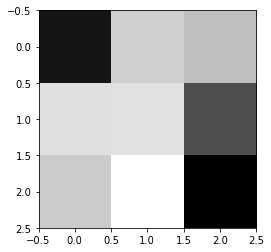

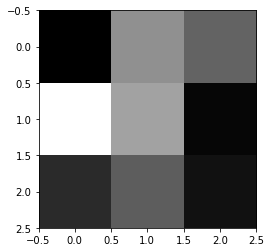

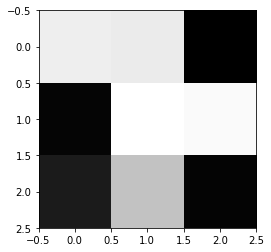

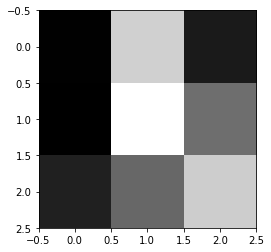

In [27]:
for i in range(32):
    plt.imshow(conv2d_1_weight[i, 0])
    plt.show()

### Getting layer properties

The layer objects themselfs expose most properties as attributes.

In [30]:
conv2d_1 = model[0]

In [32]:
conv2d_1.kernel_size

(3, 3)

In [34]:
conv2d_1.stride

(1, 1)

In [33]:
conv2d_1.dilation

(1, 1)

In [35]:
conv2d_1.in_channels, conv2d_1.out_channels

(1, 32)

In [36]:
conv2d_1.padding

(0, 0)

In [31]:
conv2d_1.output_padding

(0, 0)

In [43]:
dropout_1 = model[5]

In [44]:
dropout_1.p

0.25

In [45]:
dense_1 = model[7]

In [46]:
dense_1.in_features, dense_1.out_features

(3872, 64)